# Lab 04: Functional spatial image processing

The purpose of this lab is to practice registration steps that transform a functional image to higher-resolution anatomical space of the same subject, and then to standard space. 

## Preparation
* Import python tools for plotting 3D images
* Copy images from Lab 03 for our sub-97 example that we've been working with

In [1]:
%matplotlib inline
from nilearn import plotting
from nilearn import image

In [20]:
%%bash
# Copy files from previous labs so it is easier work with them here

# Files from 03 Lab that include our transforms for T1->MNI
cp ../03-Lab/my_T1_brain.nii.gz my_T1_brain.nii.gz
cp ../03-Lab/my_T1.nii.gz my_T1.nii.gz
cp ../03-Lab/MNI152_T1_2mm_brain.nii.gz MNI152_T1_2mm_brain.nii.gz
cp ../03-Lab/MNI152_T1_2mm.nii.gz MNI152_T1_2mm.nii.gz
cp ../03-Lab/T1_2_MNI.mat T1_2_MNI.mat # affine
cp ../03-Lab/T1_2_MNI_warp.nii.gz T1_2_MNI_warp.nii.gz # non-linear warp
cp ../03-Lab/my_T1_brain_seg_2.nii.gz my_T1_brain_wmseg.nii.gz 

# Copy functional image from osfshare
cp ../01-Lab/osfshare/sub-97_task-flanker_bold.nii.gz my_bold.nii.gz

## Registration of functional image to T1

Summary of steps 
* Extract reference volume from the 4D functional image data set 
    * fslroi tool is handy for this
   
* Estimation: 
    * Boundary Based Registration (BBR) which in theory is most accurate but takes a bit of time to run (try at home)
    * 6 degree of freedom (DOF) co-registration (faster, practice in class)

In [4]:
# There are 315 volumes in this functional data set, it doesn't make a big deal whether you round up or down
315/2

157.5

In [5]:
%%bash
fslroi


Usage: fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize>
       fslroi <input> <output> <tmin> <tsize>

       fslroi <input> <output> <xmin> <xsize> <ymin> <ysize> <zmin> <zsize> <tmin> <tsize>
Note: indexing (in both time and space) starts with 0 not 1! Inputting -1 for a size will set it to the full image extent for that dimension.


In [6]:
%%bash

# Example usage to name our middle volume as example_func
# Reads: take input of my_bold, give back example func after extracting volumes starting at vol 157 with length 1
# Remember since indexing of volumes starts at zero, this is the 158th volume
fslroi my_bold.nii.gz example_func.nii.gz 157 1

In [7]:
%%bash

# Take a look with fslview
# Decent gray matter/white matter contrast?
fslview example_func.nii.gz

In [31]:
%%bash

# Code for the 6 DOF func2T1 co-registration
flirt -in example_func \
-ref my_T1_brain \
-out func2T1_6dof \
-omat func2T1_6dof.mat \
-cost corratio \
-dof 6 \
-searchrx -90 90 -searchry -90 90 -searchrz -90 90 \
-interp trilinear


In [33]:
%%bash

# What did this produce? What is our main output of interest? 


## Concatenating transforms

For functional image analysis, we often need to align each individual's functional image with a standard space image. The standard space image (e.g., MNI 152 2mm) is a common reference space that we will align all our functional images to. This allows us to have a comparable image space for statistical analyses.  

So far we have:
* A transform from func to T1 
* A transform + warp from T1 to MNI 

We don't want to apply these sequentially *on the images themselves* because once the func is transformed we lose some precision in the image compared to the origal. So we'll combine these transforms mathematically with FSL's convert_xfm tool. 

In [37]:
%%bash

# Usage
convert_xfm

convert_xfm (Version 2.1)
Tool for manipulating FSL transformation matrices
Copyright(c) 1999-2007, University of Oxford (Mark Jenkinson)

Usage: convert_xfm [options] <input-matrix-filename>
  e.g. convert_xfm -omat <outmat> -inverse <inmat>
       convert_xfm -omat <outmat_AtoC> -concat <mat_BtoC> <mat_AtoB>

  Available options are:
        -omat <matrix-filename>            (4x4 ascii format)
        -concat <second-matrix-filename>
        -fixscaleskew <second-matrix-filename>
        -inverse                           (Reference image must be the one originally used)
        -help


Our A, B, C for affine matrices:

A: func  
B: T1   
C: standard  

In [38]:
%%bash 
ls

example_func.nii.gz
func2T1_6dof.mat
func2T1_6dof.nii.gz
func2T1_fast_wmedge.nii.gz
func2T1_fast_wmseg.nii.gz
func2T1_init.mat
func2T1.mat
func2T1.nii.gz
FunctionalSpatialImageProcessing.ipynb
MNI152_T1_2mm_brain.nii.gz
MNI152_T1_2mm.nii.gz
my_bold.nii.gz
my_T1_brain.nii.gz
my_T1.nii.gz
preproc.feat
T1_2_MNI.mat
T1_2_MNI_warp.nii.gz


In [39]:
%%bash

# Write the command out for our affine matrices
convert_xfm -omat func2standard -concat T1_2_MNI.mat func2T1.mat

In [41]:
%%bash

# Next we need to use convertwarp to concatenate our combined affine with our nonlinear warp
# Usage
convertwarp


Part of FSL (build 509)
convertwarp
Copyright(c) 2001-2012, University of Oxford

Usage: 
convertwarp -m affine_matrix_file -r refvol -o output_warp
convertwarp --ref=refvol --premat=mat1 --warp1=vol1 --warp2=vol2 --postmat=mat2 --out=output_warp
convertwarp -r refvol -s shiftmapvol -o output_warp

Compulsory arguments (You MUST set one or more of):
	-o,--out	filename for output (warp) image - always in 'field' format
	-r,--ref	filename for reference image

Optional arguments (You may optionally specify one or more of):
	-m,--premat	filename of pre-affine transform
	-w,--warp1	filename for initial warp (follows pre-affine)
	--midmat	filename of mid-warp-affine transform
	--warp2	filename for secondary warp (after initial warp, before post-affine)
	--postmat	filename of post-affine transform
	-s,--shiftmap	filename for shiftmap (applied first)
	-d,--shiftdir	direction to apply shiftmap {x,y,z,x-,y-,z-}
	-j,--jacobian	calculate and save Jacobian of final warp field
	--jstats	print out s

In [42]:
%%bash

# Concatenate
convertwarp --ref=MNI152_T1_2mm_brain --premat=func2T1.mat --warp1=T1_2_MNI_warp --out=func2MNI_warp

In [44]:
%%bash

# Apply concatenated transform
applywarp --ref=MNI152_T1_2mm_brain --in=example_func --out=func2MNI --warp=func2MNI_warp

In [45]:
%%bash

# Let's take a look in fslview
fslview MNI152_T1_2mm_brain.nii.gz func2MNI.nii.gz

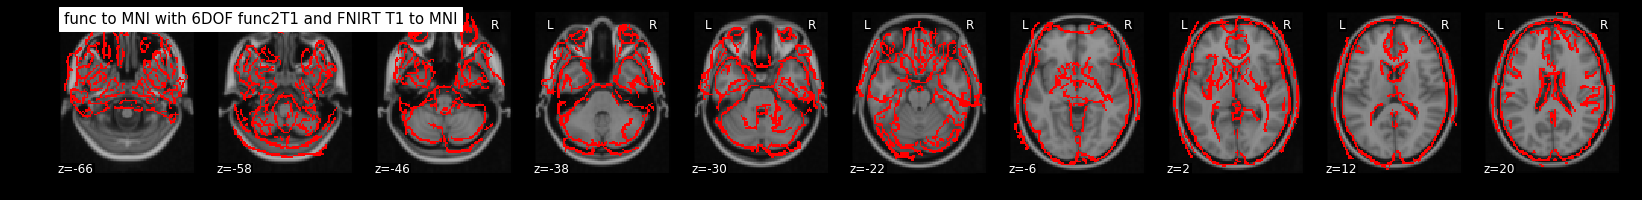

In [72]:
# Plot a more static image with edge overlay
mni="MNI152_T1_2mm.nii.gz"
fimg="func2MNI.nii.gz"
display=plotting.plot_anat(mni, display_mode="z",cut_coords=10,title="func to MNI with 6DOF func2T1 and FNIRT T1 to MNI")
display.add_edges(fimg)

## Invert transform of functional to MNI and apply to a mask

So far we have gone in this direction: func -> T1 -> MNI  
We can invert our transforms to go in the opposite direction: func <- T1 <- MNI  

In [46]:
%%bash

# We need to invert our warp from T1_2_MNI to get the MNI_2_T1 warp
# Generic usage: invwarp -w A2B_warp -o B2A_warp -r A
invwarp -w T1_2_MNI_warp -o MNI_2_T1_warp -r my_T1_brain.nii.gz

In [48]:
%%bash

# We can invert our func2T1.mat with convert_xfm
# Try this below, name the inverted matrix T12func.mat
convert_xfm -omat T12func.mat -inverse func2T1.mat

convert_xfm (Version 2.1)
Tool for manipulating FSL transformation matrices
Copyright(c) 1999-2007, University of Oxford (Mark Jenkinson)

Usage: convert_xfm [options] <input-matrix-filename>
  e.g. convert_xfm -omat <outmat> -inverse <inmat>
       convert_xfm -omat <outmat_AtoC> -concat <mat_BtoC> <mat_AtoB>

  Available options are:
        -omat <matrix-filename>            (4x4 ascii format)
        -concat <second-matrix-filename>
        -fixscaleskew <second-matrix-filename>
        -inverse                           (Reference image must be the one originally used)
        -help


In [49]:
%%bash

# Extracting an atlas-based region of interest in MNI space
# Copy the Harvard-Oxford sub-cortical atlas from fsl's library to our working directory
cp /usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr50-2mm.nii.gz HarvardOxford-sub-maxprob-thr50-2mm.nii.gz

In [50]:
%%bash
fslview HarvardOxford-sub-maxprob-thr50-2mm.nii.gz

In [51]:
%%bash

# Example for extracting the left putamen (intensity 6)
fslmaths HarvardOxford-sub-maxprob-thr50-2mm.nii.gz -thr 6 -uthr 6 Lputamen.nii.gz

In [53]:
%%bash

# Did it work?
fslview MNI152_T1_2mm_brain.nii.gz Lputamen.nii.gz

In [54]:
%%bash

# Finally we can use apply warp to apply both our nonlinear and affine warps at once to our functional
# This is typically done when we want to put a regional mask in standard space into functional space 
# e.g., for our atlas-based ROI of the caudate
applywarp -i Lputamen -r example_func -o Lputamen_mask_func -w MNI_2_T1_warp --postmat=T12func.mat

In [56]:
%%bash

# Did it work?  What are the intensity values in the mask and on edges?
fslview example_func.nii.gz Lputamen_mask_func.nii.gz

In [64]:
%%bash

# Dealing with edge effects in transformed masks
# How could we threshold this to manage edge bleeds?

fslmaths Lputamen_mask_func.nii.gz -thr 5.5 -bin Lputamen_mask_func_thr_bin.nii.gz

In [65]:
%%bash

# See if you like
fslview example_func.nii.gz Lputamen_mask_func.nii.gz Lputamen_mask_func_thr_bin.nii.gz

/home/brain/.packages/miniconda3/lib/python3.6/site-packages/nilearn/image/resampling.py:518: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/brain/.packages/miniconda3/lib/python3.6/site-packages/numpy/ma/core.py:2809: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


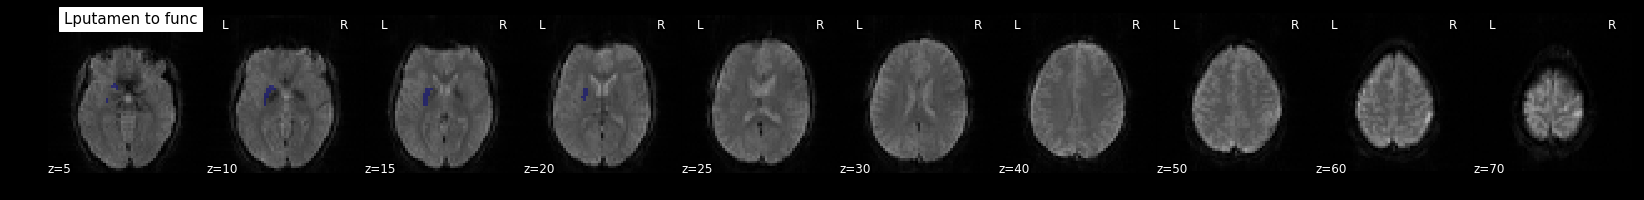

In [82]:
# Plot a more static image with some transparency using alpha setting
fimg="example_func.nii.gz"
roi="Lputamen_mask_func_thr_bin.nii.gz"
plotting.plot_roi(roi,fimg, display_mode="z",cut_coords=10,alpha=.5,title="Lputamen to func")

Why can't we use this to extract the timeseries from this region in the my_bold.nii.gz image yet?

## Problem sets

*1a)* Use the epi_reg tool to generate a transform from functional to T1 space, and combine these transforms to complete a registration of the functional to MNI using BBR for the functional step.
* Name the output of bbr func2T1_bbr
* Name the output of the final concatenated warp func2MNI_bbr 

In [8]:
%%bash

# Examine usage below
epi_reg


Usage: epi_reg [options] --epi=<EPI image> --t1=<wholehead T1 image> --t1brain=<brain extracted T1 image> --out=<output name>
 
Optional arguments
  --fmap=<image>         : fieldmap image (in rad/s)
  --fmapmag=<image>      : fieldmap magnitude image - wholehead extracted
  --fmapmagbrain=<image> : fieldmap magnitude image - brain extracted
  --wmseg=<image>        : white matter segmentation of T1 image
  --echospacing=<val>    : Effective EPI echo spacing (sometimes called dwell time) - in seconds
  --pedir=<dir>          : phase encoding direction, dir = x/y/z/-x/-y/-z
  --weight=<image>       : weighting image (in T1 space)
  --nofmapreg            : do not perform registration of fmap to T1 (use if fmap already registered) 
  --noclean              : do not clean up intermediate files
  -v                     : verbose output
  -h                     : display this help message
 
e.g.:  epi_reg --epi=example_func --t1=struct --t1brain=struct_brain --out=epi2struct --fmap=fmap_ra

In [29]:
%%bash

# The epi_reg command will take some time because there appears to be a bug when you supply your own _wmseg
epi_reg --epi=example_func --t1=my_T1 --t1brain=my_T1_brain --out=func2T1

Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.536758 0.999835 -0.015919 -0.008741 0.000000 0.015846 0.999839 -0.008359 0.000000 0.008872 0.008219 0.999927 0.000000 -2.332991 2.286299 6.458590 1.000000 


*1b)*  Comment on whether you think BBR did a better job and why or why not. Feel free to use figures to help visualize your comparison. 

*2)* Extract a different region of interest from the Harvard Oxford atlas. Describe the anatomical region you chose and complete steps to register your mask to the functional bold image. Show your steps below and create a figure with nilearn to visualize your ROI on the reference functional image.

In [ ]:
%%bash

# Your code 

In [83]:
# Code for your ROI figure